# Feature Selection

## Optimizing VALUE
### Utilizing IG
For datasets with entirely categorical features, Information Gain (IG) is often the better choice.
Information Gain directly computes entropy and conditional entropy values, making it inherently suited for categorical variables without needing complex estimators. It naturally handles categorical splits, aligning with how information gain is used in decision trees and rule-based methods.

In [1]:
import pandas as pd
import numpy as np

from ucimlrepo import fetch_ucirepo
from scipy.stats import entropy

In [47]:
def entropy(counts):
    """
    Calculate the entropy of a set of counts.
    """
    probabilities = counts / np.sum(counts)
    return -np.sum(probabilities * np.log2(probabilities + 1e-10))  # Adding small value to avoid log(0)

def information_gain(X, y, feature):
    """
    Calculate the information gain of a categorical feature with respect to the target variable y.
    """
    y = np.array(y).flatten()
    y = (y == 1).astype(int)
    
    total_entropy = entropy(np.bincount(y))
    
    values, counts = np.unique(X[feature], return_counts=True)
    conditional_entropy = 0
    for value, count in zip(values, counts):
        y_given_x = y[X[feature] == value]
        conditional_entropy += (count / len(X)) * entropy(np.bincount(y_given_x))
    return total_entropy - conditional_entropy

In [3]:
phishing_websites = fetch_ucirepo(id=327)
X = phishing_websites.data.features
y = phishing_websites.data.targets

In [65]:
ig_values = {feature: information_gain(X, y, feature) for feature in X.columns}
ig_values = sorted(ig_values.items(), key=lambda item: item[1], reverse=True)

In [ ]:
def rank_features_by_ig(ig_values):
    return sorted(ig_values.items(), key=lambda item: item[1], reverse=True)

ranked_features = rank_features_by_ig(dict(ig_values))

print("Ranked features based on Information Gain:")
for rank, (feature, ig) in enumerate(ranked_features, start=1):
    print(f"{rank}. {feature}: {ig:.4f}")

Ranked features based on Information Gain:
1. sslfinal_state: 0.4995
2. url_of_anchor: 0.4773
3. prefix_suffix: 0.1234
4. web_traffic: 0.1146
5. having_sub_domain: 0.1097
6. links_in_tags: 0.0470
7. request_url: 0.0466
8. sfh: 0.0375
9. domain_registration_length: 0.0368
10. google_index: 0.0119
11. age_of_domain: 0.0107
12. page_rank: 0.0080
13. having_ip_address: 0.0064
14. statistical_report: 0.0046
15. links_pointing_to_page: 0.0044
16. dnsrecord: 0.0041
17. url_length: 0.0038
18. shortining_service: 0.0034
19. abnormal_url: 0.0027
20. having_at_symbol: 0.0020
21. on_mouseover: 0.0013
22. https_token: 0.0012
23. double_slash_redirecting: 0.0011
24. port: 0.0010
25. redirect: 0.0003
26. submitting_to_email: 0.0002
27. rightclick: 0.0001
28. iframe: 0.0000
29. favicon: 0.0000
30. popupwindow: 0.0000


Top 5 features based on Information Gain:
sslfinal_state: 0.4995
url_of_anchor: 0.4773
prefix_suffix: 0.1234
web_traffic: 0.1146
having_sub_domain: 0.1097


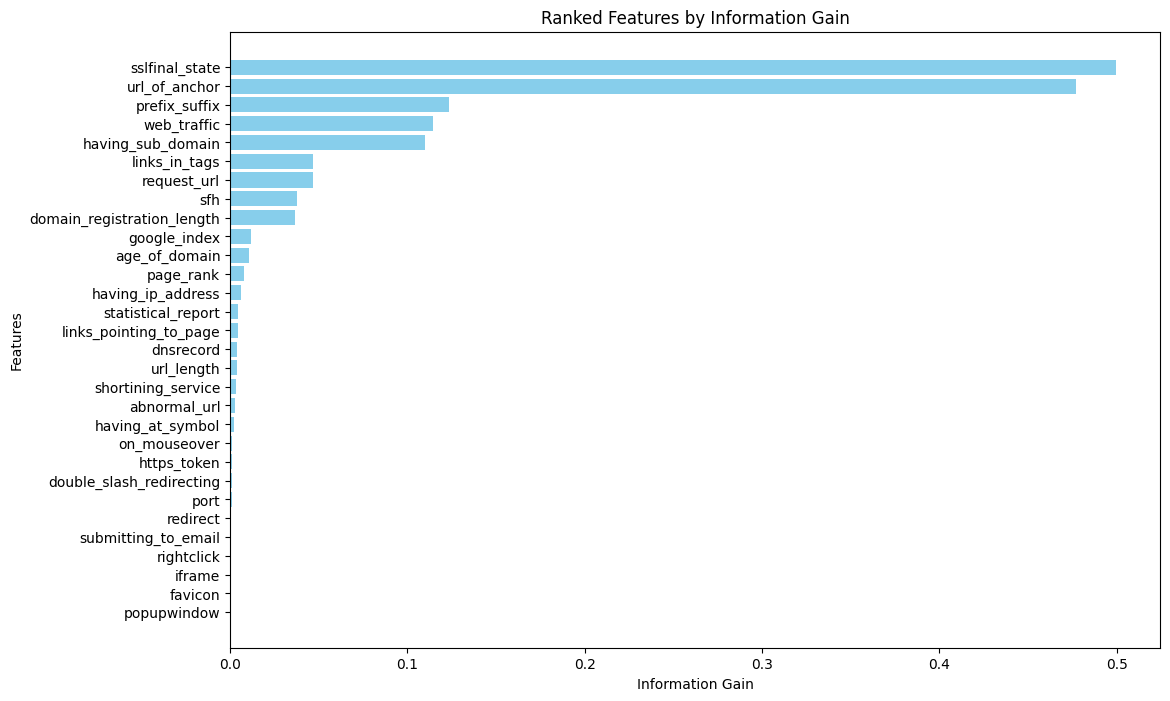

In [50]:
import matplotlib.pyplot as plt

features = [feature for feature, ig in ranked_features]
ig_values = [ig for feature, ig in ranked_features]

plt.figure(figsize=(12, 8))
plt.barh(features, ig_values, color='skyblue')
plt.xlabel('Information Gain')
plt.ylabel('Features')
plt.title('Ranked Features by Information Gain')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
def get_top_k_features(ig_values, k):
    return sorted(ig_values.items(), key=lambda item: item[1], reverse=True)[:k]

top_k_features = get_top_k_features(dict(ig_values), k=10)
print("Top 5 features based on Information Gain:")
for feature, ig in top_k_features:
    print(f"{feature}: {ig:.4f}")

## Optimizing TIME
### Weights decided based on the time required to calculate each feature in a live setting

In [61]:
time_costs = {
    'sslfinal_state': 0.02,  # Low time cost
    'url_of_anchor': 0.10,    # Medium time cost
    'prefix_suffix': 0.05,    # Low time cost
    'web_traffic': 0.30,      # High time cost
    'having_sub_domain': 0.15, # Medium time cost
    'links_in_tags': 0.07,    # Medium time cost
    'request_url': 0.09,      # Medium time cost
    'sfh': 0.04,              # Low time cost
    'domain_registration_length': 0.06, # Low time cost
    'google_index': 0.03,     # Low time cost
    'age_of_domain': 0.06,    # Low time cost
    'page_rank': 0.02,        # Low time cost
    'having_ip_address': 0.9, # Low time cost
    'statistical_report': 0.10, # Medium time cost
    'links_pointing_to_page': 0.08, # Medium time cost
    'dnsrecord': 0.07,        # Medium time cost
    'url_length': 0.04,       # Low time cost
    'shortining_service': 0.12, # Medium time cost
    'abnormal_url': 0.09,     # Medium time cost
    'having_at_symbol': 0.02, # Low time cost
    'on_mouseover': 0.03,     # Low time cost
    'https_token': 0.05,      # Low time cost
    'double_slash_redirecting': 0.02, # Low time cost
    'port': 0.01,             # Low time cost
    'redirect': 0.03,         # Low time cost
    'submitting_to_email': 0.01, # Low time cost
    'rightclick': 0.01,       # Low time cost
    'iframe': 0.02,           # Low time cost
    'favicon': 0.02,          # Low time cost
    'popupwindow': 0.02       # Low time cost
}

w_IG = 0.7
w_TC = 0.3


In [ ]:
composite_scores = {}
ig_values = {feature: information_gain(X, y, feature) for feature in X.columns}
ig_values = sorted(ig_values.items(), key=lambda item: item[1], reverse=True)
ranked_features = rank_features_by_ig(dict(ig_values))

for feature, ig in ranked_features:
    time_cost = time_costs.get(feature, 0.0)
    composite_score = w_IG * ig + w_TC * (1 + time_cost)
    composite_scores[feature] = composite_score

In [67]:
ranked_features = sorted(composite_scores.items(), key=lambda item: item[1], reverse=True)

print("Ranked Features Based on Composite Score (IG and Time Cost):")
for rank, (feature, score) in enumerate(ranked_features, start=1):
    print(f"{rank}. {feature}: {score:.4f}")

Ranked Features Based on Composite Score (IG and Time Cost):
1. url_of_anchor: 0.6641
2. sslfinal_state: 0.6556
3. having_ip_address: 0.5745
4. web_traffic: 0.4702
5. having_sub_domain: 0.4218
6. prefix_suffix: 0.4014
7. request_url: 0.3596
8. links_in_tags: 0.3539
9. domain_registration_length: 0.3438
10. shortining_service: 0.3384
11. sfh: 0.3382
12. statistical_report: 0.3332
13. abnormal_url: 0.3289
14. links_pointing_to_page: 0.3271
15. age_of_domain: 0.3255
16. dnsrecord: 0.3239
17. google_index: 0.3173
18. https_token: 0.3158
19. url_length: 0.3147
20. page_rank: 0.3116
21. on_mouseover: 0.3099
22. redirect: 0.3092
23. having_at_symbol: 0.3074
24. double_slash_redirecting: 0.3068
25. iframe: 0.3060
26. favicon: 0.3060
27. popupwindow: 0.3060
28. port: 0.3037
29. submitting_to_email: 0.3032
30. rightclick: 0.3031


### Wighted composite score formula
```
\[
\text{Composite Score}_i = w_{\text{IG}} \cdot \text{IG}_i + w_{\text{TC}} \cdot \left( \frac{1}{1 + \text{Time Cost}_i} \right)
\]
```